0 0 * * * /usr/bin/python3 /path/to/ingestion_script.py

Example command to be used to Automate data ingestion with a Cron Job. It would require this pipeline to be in a python file, instead of a notebook. We will not do that here but we provided the command for reference of how it would be done. This command would run part of this notebook which is related to the batch ingestion at midnight every day

In [0]:
%load_ext autoreload
%autoreload 2
# Enables autoreload; learn more at https://docs.databricks.com/en/files/workspace-modules.html#autoreload-for-python-modules
# To disable autoreload; run %autoreload 0

# Imports

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType, DoubleType
from pyspark.sql import DataFrame
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from difflib import get_close_matches
from datetime import datetime
import time
from delta.tables import DeltaTable

from logger import log_message

#Functions

In [0]:
# Function to detect schema changes (with column mapping for renamed columns)
def schema_evolution(new_df, reference_df):
    # Extract data types from both DataFrames
    new_dtypes = dict(new_df.dtypes)
    ref_dtypes = dict(reference_df.dtypes)

    # Detect new and dropped columns
    new_cols = set(new_dtypes.keys()) - set(ref_dtypes.keys())
    dropped_cols = set(ref_dtypes.keys()) - set(new_dtypes.keys())

    # Detect type changes by matching similar column names
    changed_types = {}
    for new_col in new_dtypes:
        closest_match = get_close_matches(new_col, ref_dtypes.keys(), n=1)
        if closest_match:
            ref_col = closest_match[0]
            if ref_dtypes[ref_col] != new_dtypes[new_col]:
                changed_types[new_col] = (ref_dtypes[ref_col], new_dtypes[new_col])

    print(f"New Columns: {new_cols}")
    print(f"Dropped Columns: {dropped_cols}")
    print(f"Changed Data Types: {changed_types}")


In [0]:
def validate_schema(df, expected_schema):
    schema1_dict = {field.name: field.dataType for field in df.schema.fields}
    schema2_dict = {field.name: field.dataType for field in expected_schema.fields}

    schema_same = True
    for col in schema1_dict.keys() | schema2_dict.keys():
        if schema1_dict.get(col) != schema2_dict.get(col):
            print(f"Column '{col}' has different types: {schema1_dict.get(col)} vs {schema2_dict.get(col)}")
            schema_same = False

    if schema_same:
        print("Schema is the same.")
        log_message("info", "medallion", "schema validation", "Schema validation passed")
        return True
    else:
        print("Schema is different.")
        log_message("warning", "medallion", "schema validation", "Schema validation failed")
        return False

In [0]:
def data_integrity_check(df, df_name, save_path):
    """
    Performs data integrity checks on the given DataFrame:
    - Identifies integer columns dynamically
    - Checks for invalid values (e.g., negative integers)
    - Checks for null values
    - Checks for duplicates
    - Removes invalid data and saves the cleaned DataFrame
    """
    print(f"\nPerforming Data Integrity Checks for {df_name}...")

    # Identify integer columns
    integer_columns = [field.name for field in df.schema.fields if field.dataType.simpleString() == "int"]

    # 1. Check for Negative or Zero Values in Integer Columns
    for col_name in integer_columns:
        invalid_count = df.filter(F.col(col_name) < 0).count()
        if invalid_count > 0:
            print(f"Invalid values in '{col_name}': {invalid_count}")

    # 2. Check for Null Values in Key Columns
    null_values = df.select(
        [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]
    )

    # 3. Check for Duplicates
    initial_count = df.count()
    distinct_count = df.dropDuplicates().count()

    # Display Results
    print(f"Null Value Check:")
    null_values.show()

    if initial_count != distinct_count:
        print(f"Duplicate Rows Detected: {initial_count - distinct_count}")
    else:
        print("No Duplicates Found")

    # Optional: Remove Invalid Data and Save the Cleaned Data
    cleaned_df = df
    for col_name in integer_columns:
        cleaned_df = cleaned_df.filter(F.col(col_name) >= 0)

    cleaned_df = cleaned_df.dropna().dropDuplicates()

    # Save Cleaned Data
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = cleaned_df.toPandas()

    # Save as CSV
    save_path = f"{save_path}{df_name}.csv"
    pandas_df.to_csv(save_path, index=False)
    print(f"Cleaned {df_name} successfully saved at {save_path}")
    log_message("info", "medallion", "data integrity check", f"Cleaned {df_name} successfully saved at {save_path}")

In [0]:
base_path = "file:/Workspace/Users/masa.cirkovic@abo.fi/"
raw_data_path = base_path + "rawdata/"
bronze_path = base_path + "medallion/bronze/"
silver_path = base_path + "medallion/silver/"
gold_path = base_path + "medallion/gold/"

# Bronze Layer (with Automated Batch Ingestion)

In [0]:
bronze_statistics_df = pd.DataFrame(columns=["file", "records", "size_bytes", "format", "ingestion_time_s", "timestamp"])

## Car Sales Data

In [0]:
car_sales_path = raw_data_path + "car_sales_data.csv"

# Read the raw car_sales data from CSV
try:
    start_time = time.time()
    car_sales_df = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(car_sales_path)
    ingestion_time = time.time() - start_time

    # Whitespaces in the columns names were giving error-> all spaces were changed with underlines
    car_sales_df = car_sales_df.select([col(c).alias(c.replace(" ", "_")) for c in car_sales_df.columns])

    # Populate query statistics
    size = os.path.getsize(car_sales_path.split("file:")[1])
    new_row = pd.DataFrame([{
        "file": "car_sales_data",
        "records": car_sales_df.count(),
        "size_bytes": size,
        "format": "csv",
        "ingestion_time_s": ingestion_time,
        "timestamp": datetime.now()
    }])
    bronze_statistics_df = pd.concat([bronze_statistics_df, new_row], ignore_index=True)

    # Display the first 5 rows and schema
    car_sales_df.show(5)
    car_sales_df.printSchema() # Bronze folder path

    log_message("info", "medallion", "bronze_ingestion", f"Raw car_sales_data successfully read")
except Exception as e:
    print(f"Error: {e}")
    log_message("error", "medallion", "bronze_ingestion", f"Error reading raw car_sales_data: {e}")

+---+------------+----------+--------------------+-------------+-------+----------+--------------------+------------+----------+----------+--------+
|_c0|         car|      date|         dealer_name|dealer_region|company|     model|              engine|transmission| color_car|body_style| price_$|
+---+------------+----------+--------------------+-------------+-------+----------+--------------------+------------+----------+----------+--------+
|  0|C_CND_000001|2022-01-02|Buddy Storbeck's ...|   Middletown|CMP_001|Expedition|DoubleÂ Overhead ...|        Auto|     Black|       SUV|$26,000 |
|  1|C_CND_000002|2022-01-02|    C & M Motors Inc|       Aurora|CMP_002|   Durango|DoubleÂ Overhead ...|        Auto|     Black|       SUV|$19,000 |
|  2|C_CND_000003|2022-01-02|         Capitol KIA|   Greenville|CMP_003|  Eldorado|   Overhead Camshaft|      Manual|       Red| Passenger|$31,500 |
|  3|C_CND_000004|2022-01-02|Chrysler of Tri-C...|        Pasco|CMP_004|    Celica|   Overhead Camshaft|  

In [0]:
bronze_car_sales_path = bronze_path + "car_sales_data"

# Write raw data to Bronze Layer as a Delta table
try:
    car_sales_df.write.format("delta") \
        .mode("overwrite") \
        .option("overwriteSchema", "true") \
        .save(bronze_car_sales_path)

    print("Raw car_sales data successfully ingested into the Bronze Layer.")

    # Read back the data for confirmation
    bronze_car_sales_df = spark.read.format("delta").load(bronze_car_sales_path)
    bronze_car_sales_df.show(5)

    log_message("info", "medallion", "bronze_ingestion", f"Raw car_sales_data successfully ingested into the Bronze Layer")
except Exception as e:
    print(f"Error: {e}")
    log_message("error", "medallion", "bronze_ingestion", f"Error ingesting raw car_sales_data into the Bronze Layer: {e}")

Raw car_sales data successfully ingested into the Bronze Layer.
+---+------------+----------+--------------------+-------------+-------+----------+--------------------+------------+----------+----------+--------+
|_c0|         car|      date|         dealer_name|dealer_region|company|     model|              engine|transmission| color_car|body_style| price_$|
+---+------------+----------+--------------------+-------------+-------+----------+--------------------+------------+----------+----------+--------+
|  0|C_CND_000001|2022-01-02|Buddy Storbeck's ...|   Middletown|CMP_001|Expedition|DoubleÂ Overhead ...|        Auto|     Black|       SUV|$26,000 |
|  1|C_CND_000002|2022-01-02|    C & M Motors Inc|       Aurora|CMP_002|   Durango|DoubleÂ Overhead ...|        Auto|     Black|       SUV|$19,000 |
|  2|C_CND_000003|2022-01-02|         Capitol KIA|   Greenville|CMP_003|  Eldorado|   Overhead Camshaft|      Manual|       Red| Passenger|$31,500 |
|  3|C_CND_000004|2022-01-02|Chrysler of T

## Companies Data

In [0]:
companies_path = raw_data_path + "companies_data.json"

# Read the raw companies data from JSON
try:
    start_time = time.time()
    companies_df = spark.read.format("json") \
        .option("inferSchema", "true") \
        .load(companies_path)
    ingestion_time = time.time() - start_time

    # Whitespaces in the columns names were giving error-> all spaces were changed with underlines
    companies_df = companies_df.select([col(c).alias(c.replace(" ", "_")) for c in companies_df.columns])

    # Populate query statistics
    size = os.path.getsize(companies_path.split("file:")[1])
    new_row = pd.DataFrame([{
        "file": "companies_data",
        "records": companies_df.count(),
        "size_bytes": size,
        "format": "json",
        "ingestion_time_s": ingestion_time,
        "timestamp": datetime.now()
    }])
    bronze_statistics_df = pd.concat([bronze_statistics_df, new_row], ignore_index=True)

    # Display the first 5 rows and schema
    companies_df.show(5)
    companies_df.printSchema()

    log_message("info", "medallion", "bronze_ingestion", f"Raw companies_data successfully read")
except Exception as e:
    print(f"Error: {e}")
    log_message("error", "medallion", "bronze_ingestion", f"Error reading raw companies_data: {e}")

+----------+------------+------------+-------------+-------------+
|company_id|company_name|company_type|founding_year| headquarters|
+----------+------------+------------+-------------+-------------+
|   CMP_001|        Ford|     private|         1903|United States|
|   CMP_002|       Dodge|    division|         1900|           US|
|   CMP_003|    Cadillac|    division|         1902|United States|
|   CMP_004|      Toyota|     private|         1937|        Japan|
|   CMP_005|       Acura|    division|         1986|United States|
+----------+------------+------------+-------------+-------------+
only showing top 5 rows
root
 |-- company_id: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_type: string (nullable = true)
 |-- founding_year: long (nullable = true)
 |-- headquarters: string (nullable = true)



In [0]:
# Bronze folder path
bronze_companies_path = bronze_path + "companies_data"

# Write raw data to Bronze Layer as a Delta table
try:
    companies_df.write.format("delta") \
        .mode("overwrite") \
        .option("overwriteSchema", "true") \
        .save(bronze_companies_path)

    print("Raw company data successfully ingested into the Bronze Layer.")

    # Read back the data for confirmation
    bronze_companies_df = spark.read.format("delta").load(bronze_companies_path)
    bronze_companies_df.show(5)

    log_message("info", "medallion", "bronze_ingestion", f"Raw companies_data successfully ingested into the Bronze Layer")
except Exception as e:
    print(f"Error: {e}")
    log_message("error", "medallion", "bronze_ingestion", f"Error ingesting raw companies_data into the Bronze Layer: {e}")

Raw company data successfully ingested into the Bronze Layer.
+----------+------------+------------+-------------+-------------+
|company_id|company_name|company_type|founding_year| headquarters|
+----------+------------+------------+-------------+-------------+
|   CMP_001|        Ford|     private|         1903|United States|
|   CMP_002|       Dodge|    division|         1900|           US|
|   CMP_003|    Cadillac|    division|         1902|United States|
|   CMP_004|      Toyota|     private|         1937|        Japan|
|   CMP_005|       Acura|    division|         1986|United States|
+----------+------------+------------+-------------+-------------+
only showing top 5 rows


## Customers Data

In [0]:
customers_path = raw_data_path + "customers_data.csv"

# Read the raw customers data from CSV
try:
    start_time = time.time()
    customers_df = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(customers_path)
    ingestion_time = time.time() - start_time

    # Whitespaces in the columns names were giving error-> all spaces were changed with underlines
    customers_df = customers_df.select([col(c).alias(c.replace(" ", "_")) for c in customers_df.columns])

    # Populate query statistics
    size = os.path.getsize(customers_path.split("file:")[1])
    new_row = pd.DataFrame([{
        "file": "customers_data",
        "records": customers_df.count(),
        "size_bytes": size,
        "format": "csv",
        "ingestion_time_s": ingestion_time,
        "timestamp": datetime.now()
    }])
    bronze_statistics_df = pd.concat([bronze_statistics_df, new_row], ignore_index=True)

    # Display the first 5 rows and schema
    customers_df.show(5)
    customers_df.printSchema()

    log_message("info", "medallion", "bronze_ingestion", f"Raw customers_data successfully read")
except Exception as e:
    print(f"Error: {e}")
    log_message("error", "medallion", "bronze_ingestion", f"Error reading raw customers_data: {e}")

+------------+---------+------+-------------+
|      car_id|     name|gender|annual_income|
+------------+---------+------+-------------+
|C_CND_000001|Geraldine|  Male|     $13,500 |
|C_CND_000002|      Gia|  Male|  $1,480,000 |
|C_CND_000003|   Gianna|  Male|  $1,035,000 |
|C_CND_000004|  Giselle|  Male|     $13,500 |
|C_CND_000005|    Grace|  Male|  $1,465,000 |
+------------+---------+------+-------------+
only showing top 5 rows
root
 |-- car_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- annual_income: string (nullable = true)



In [0]:
bronze_customers_path = bronze_path + "customers_data"

# Write raw data to Bronze Layer as a Delta table
try:
    customers_df.write.format("delta") \
        .mode("overwrite") \
        .option("overwriteSchema", "true") \
        .save(bronze_customers_path)

    print("Raw customers data successfully ingested into the Bronze Layer.")

    # Read back the data for confirmation
    bronze_customers_df = spark.read.format("delta").load(bronze_customers_path)
    bronze_customers_df.show(5)

    log_message("info", "medallion", "bronze_ingestion", f"Raw customers_data successfully ingested into the Bronze Layer")
except Exception as e:
    print(f"Error: {e}")
    log_message("error", "medallion", "bronze_ingestion", f"Error ingesting raw_customers data into the Bronze Layer: {e}")

Raw customers data successfully ingested into the Bronze Layer.
+------------+---------+------+-------------+
|      car_id|     name|gender|annual_income|
+------------+---------+------+-------------+
|C_CND_000001|Geraldine|  Male|     $13,500 |
|C_CND_000002|      Gia|  Male|  $1,480,000 |
|C_CND_000003|   Gianna|  Male|  $1,035,000 |
|C_CND_000004|  Giselle|  Male|     $13,500 |
|C_CND_000005|    Grace|  Male|  $1,465,000 |
+------------+---------+------+-------------+
only showing top 5 rows


In [0]:
display(bronze_statistics_df)

file,records,size_bytes,format,ingestion_time_s,timestamp
car_sales_data,24183,3183621,csv,1.4347023963928223,2025-03-20T11:20:38.756914Z
companies_data,30,3666,json,0.7672467231750488,2025-03-20T11:20:47.309681Z
customers_data,23906,900887,csv,1.098609209060669,2025-03-20T11:20:54.300341Z


# Silver Layer

In [0]:
silver_statistics_df = pd.DataFrame(columns=["file", "old_records", "missing_values", "duplicates", "anomalies", "new_records", "timestamp"])

## Car Sales Data

In [0]:
silver_car_sales_df = bronze_car_sales_df.select("*")

### Renaming Columns

In [0]:
# Drop the `_c0` column as it has already another id column
silver_car_sales_df = silver_car_sales_df.drop("_c0")

print("Column `_c0` successfully removed.")

Column `_c0` successfully removed.


In [0]:
silver_car_sales_df.columns

['car',
 'date',
 'dealer_name',
 'dealer_region',
 'company',
 'model',
 'engine',
 'transmission',
 'color_car',
 'body_style',
 'price_$']

In [0]:
rename_columns = {
    'car': 'car_id',
    'company': 'company_id',
    'color_car': 'color',
    'price': 'price_$'
}

# Apply renaming
silver_car_sales_df = silver_car_sales_df.select([
    F.col(c).alias(rename_columns.get(c, c).lower()) for c in silver_car_sales_df.columns
])

# Updated column names
silver_car_sales_df.columns

['car_id',
 'date',
 'dealer_name',
 'dealer_region',
 'company_id',
 'model',
 'engine',
 'transmission',
 'color',
 'body_style',
 'price_$']

### Changing Types

In [0]:
silver_car_sales_df.dtypes

[('car_id', 'string'),
 ('date', 'date'),
 ('dealer_name', 'string'),
 ('dealer_region', 'string'),
 ('company_id', 'string'),
 ('model', 'string'),
 ('engine', 'string'),
 ('transmission', 'string'),
 ('color', 'string'),
 ('body_style', 'string'),
 ('price_$', 'string')]

In [0]:
# Remove '$' symbol and convert to integer
silver_car_sales_df = silver_car_sales_df.withColumn(
    "price_$", 
    F.regexp_replace("price_$", "[$,]", "").cast("int")
)

# Confirm
silver_car_sales_df.select("price_$").show(5)

+-------+
|price_$|
+-------+
|  26000|
|  19000|
|  31500|
|  14000|
|  24500|
+-------+
only showing top 5 rows


### Checking Missing Values

In [0]:
# Count missing values in each column
missing_values = silver_car_sales_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in silver_car_sales_df.columns]
)

missing_values_dict = missing_values.collect()[0].asDict()
total_missing_values = sum(missing_values_dict.values())

# Display the missing values
missing_values.show()

+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+
|car_id|date|dealer_name|dealer_region|company_id|model|engine|transmission|color|body_style|price_$|
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+
|     0|   0|         13|            0|         3|   16|     5|           0|    2|         0|     24|
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+



In [0]:
total_missing_values

63

In [0]:
# Drop rows with missing values
silver_car_sales_df = silver_car_sales_df.dropna()

# Recheck missing values to confirm
missing_values = silver_car_sales_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in silver_car_sales_df.columns]
)
missing_values.show()

+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+
|car_id|date|dealer_name|dealer_region|company_id|model|engine|transmission|color|body_style|price_$|
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+
|     0|   0|          0|            0|         0|    0|     0|           0|    0|         0|      0|
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+



### Checking Duplicates

In [0]:
# Print row count before removing duplicates
old_records = silver_car_sales_df.count()
print(f"Number of rows before removing duplicates: {old_records}")

# Remove duplicates
silver_car_sales_df = silver_car_sales_df.dropDuplicates()

# Print row count after removing duplicates
new_records = silver_car_sales_df.count()
print(f"Number of rows after removing duplicates: {new_records}")

duplicates = old_records - new_records

Number of rows before removing duplicates: 24120
Number of rows after removing duplicates: 23819


### Checking Anomalies

In [0]:
unique_models = silver_car_sales_df.select("model").distinct()
display(unique_models)

model
Cirrus
Contour
Villager
RX300
SC
Cutlass
Camry
SL
Seville
Ram Wagon


In [0]:
# Remove the 'Â' character from all string columns
for column in silver_car_sales_df.columns:
    if dict(silver_car_sales_df.dtypes)[column] == 'string':
        silver_car_sales_df = silver_car_sales_df.withColumn(column, regexp_replace(col(column), "Â", ""))

# Confirm the correction
unique_engines = silver_car_sales_df.select("engine").distinct()
display(unique_engines)

engine
Overhead Camshaft
Double Overhead Camshaft


In [0]:
silver_car_sales_df.describe().show()

+-------+------------+--------------------+-------------+----------+------+--------------------+------------+-----+----------+------------------+
|summary|      car_id|         dealer_name|dealer_region|company_id| model|              engine|transmission|color|body_style|           price_$|
+-------+------------+--------------------+-------------+----------+------+--------------------+------------+-----+----------+------------------+
|  count|       23819|               23819|        23819|     23819| 23819|               23819|       23819|23819|     23819|             23819|
|   mean|        NULL|                NULL|         NULL|      NULL|  NULL|                NULL|        NULL| NULL|      NULL| 28112.83983374617|
| stddev|        NULL|                NULL|         NULL|      NULL|  NULL|                NULL|        NULL| NULL|      NULL|15072.174983555142|
|    min|C_CND_000001|Buddy Storbeck's ...|       Aurora|   CMP_001| 3-Sep|Double Overhead C...|        Auto|Black|   Hardto

In [0]:
print("Top 10 Most Expensive Cars:")
silver_car_sales_df.orderBy(F.desc("price_$")).show(10)


Top 10 Most Expensive Cars:
+------------+----------+--------------------+-------------+----------+--------+--------------------+------------+----------+----------+-------+
|      car_id|      date|         dealer_name|dealer_region|company_id|   model|              engine|transmission|     color|body_style|price_$|
+------------+----------+--------------------+-------------+----------+--------+--------------------+------------+----------+----------+-------+
|C_CND_003715|2022-07-05|Gartner Buick Hyu...|   Scottsdale|   CMP_009|   Sable|Double Overhead C...|        Auto|       Red|     Sedan| 390000|
|C_CND_013261|2023-05-02|       Suburban Ford|       Aurora|   CMP_014|Passport|   Overhead Camshaft|      Manual|Pale White|   Hardtop| 270000|
|C_CND_014554|2023-06-06|McKinney Dodge Ch...|   Scottsdale|   CMP_020|      LS|Double Overhead C...|        Auto|Pale White|     Sedan| 124000|
|C_CND_007069|2022-10-20|Star Enterprises Inc|       Aurora|   CMP_003|Eldorado|   Overhead Camshaft| 

In [0]:
print("Top 10 Cheapest Cars:")
silver_car_sales_df.orderBy(F.asc("price_$")).show(10)


Top 10 Cheapest Cars:
+------------+----------+--------------------+-------------+----------+--------+--------------------+------------+----------+----------+-------+
|      car_id|      date|         dealer_name|dealer_region|company_id|   model|              engine|transmission|     color|body_style|price_$|
+------------+----------+--------------------+-------------+----------+--------+--------------------+------------+----------+----------+-------+
|C_CND_022577|2023-12-08|    Saab-Belle Dodge|   Middletown|   CMP_007|Cavalier|   Overhead Camshaft|      Manual|Pale White|       SUV|    140|
|C_CND_020879|2023-11-11|   Chrysler Plymouth|   Middletown|   CMP_015|     I30|Double Overhead C...|        Auto|     Black|       SUV|    211|
|C_CND_008971|2022-11-30|Clay Johnson Auto...|       Austin|   CMP_020|      SC|   Overhead Camshaft|      Manual|       Red|   Hardtop|   1000|
|C_CND_013947|2023-05-23|Gartner Buick Hyu...|   Greenville|   CMP_001|  Taurus|Double Overhead C...|       

In [0]:
old_records = silver_car_sales_df.count()
print(f"Number of rows before filtering: {old_records}")

# Filter data to keep prices between $1,000 and $100,000
silver_car_sales_df = silver_car_sales_df.filter(
    (F.col("price_$") > 1000) & (F.col("price_$") < 100000)
)

print("Filtered dataset with valid price range (1000 - 100000)$.")
new_records = silver_car_sales_df.count()
print(f"Number of rows after filtering: {new_records}")

anomalies = old_records - new_records

Number of rows before filtering: 23819
Filtered dataset with valid price range (1000 - 100000)$.
Number of rows after filtering: 23813


### Saving

In [0]:
# Define the Silver folder path
silver_car_sales_path = silver_path + "car_sales_data"

# Write cleaned data to the Silver Layer
try:
    silver_car_sales_df.write.format("delta") \
        .mode("overwrite") \
        .option("mergeSchema", "true") \
        .save(silver_car_sales_path)

    print("Cleaned car_sales data successfully stored in the Silver Layer.")

    log_message("info", "medallion", "silver_ingestion", f"Cleaned car_sales_data successfully stored in the Silver Layer")
except Exception as e:
    print(f"Error writing data to the Silver Layer: {e}")
    log_message("error", "medallion", "silver_ingestion", f"Error writing car_sales_data to the Silver Layer: {e}")

Cleaned car_sales data successfully stored in the Silver Layer.


In [0]:
# Populate statistics
new_row = pd.DataFrame([{
    "file": "car_sales_data",
    "old_records": bronze_car_sales_df.count(),
    "missing_values": total_missing_values,
    "duplicates": duplicates,
    "anomalies": anomalies,
    "new_records": silver_car_sales_df.count(),
    "timestamp": datetime.now()
}])
silver_statistics_df  = pd.concat([silver_statistics_df , new_row], ignore_index=True)

## Companies Data

In [0]:
silver_companies_df = bronze_companies_df.select("*")

### Renaming Columns

In [0]:
silver_companies_df.columns

['company_id', 'company_name', 'company_type', 'founding_year', 'headquarters']

All good.

### Changing Types

In [0]:
silver_companies_df.dtypes

[('company_id', 'string'),
 ('company_name', 'string'),
 ('company_type', 'string'),
 ('founding_year', 'bigint'),
 ('headquarters', 'string')]

In [0]:
# Convert to integer
silver_companies_df = silver_companies_df.withColumn(
    "founding_year",
    col("founding_year").cast("int")
)

# Confirm results
silver_companies_df.dtypes

[('company_id', 'string'),
 ('company_name', 'string'),
 ('company_type', 'string'),
 ('founding_year', 'int'),
 ('headquarters', 'string')]

### Checking Missing Values

In [0]:
# Count missing values in each column
missing_values = silver_companies_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in silver_companies_df.columns]
)

missing_values_dict = missing_values.collect()[0].asDict()
total_missing_values = sum(missing_values_dict.values())

# Display the missing values
missing_values.show()

+----------+------------+------------+-------------+------------+
|company_id|company_name|company_type|founding_year|headquarters|
+----------+------------+------------+-------------+------------+
|         0|           0|           0|            0|           0|
+----------+------------+------------+-------------+------------+



All good.

### Checking Duplicates

In [0]:
# Print row count before removing duplicates
old_records = silver_companies_df.count()
print(f"Number of rows before removing duplicates: {old_records}")

# Remove duplicates
silver_companies_df = silver_companies_df.dropDuplicates()

# Print row count after removing duplicates
new_records = silver_companies_df.count()
print(f"Number of rows after removing duplicates: {new_records}")

duplicates = old_records - new_records

Number of rows before removing duplicates: 30
Number of rows after removing duplicates: 30


### Checking Anomalies

In [0]:
unique_headquarters = silver_companies_df.select("headquarters").distinct()
unique_headquarters.show(truncate=False)


+--------------+
|headquarters  |
+--------------+
|Sweden        |
|Germany       |
|United States |
|US            |
|South Korea   |
|Japan         |
|United Kingdom|
+--------------+



In [0]:
# Standardize 'US' to 'United States' in the headquarters column
silver_company_df = silver_companies_df.withColumn(
    "headquarters", 
    F.when(F.col("headquarters") == "US", "United States")
     .otherwise(F.col("headquarters"))
)

# Display updated headquarters values
silver_company_df.select("headquarters").distinct().show(truncate=False)

+--------------+
|headquarters  |
+--------------+
|Sweden        |
|Germany       |
|United States |
|South Korea   |
|Japan         |
|United Kingdom|
+--------------+



In [0]:
silver_companies_df.select(
    F.min("founding_year").alias("Min Year"),
    F.max("founding_year").alias("Max Year")
).show()

anomalies = 0

+--------+--------+
|Min Year|Max Year|
+--------+--------+
|    1897|    1989|
+--------+--------+



### Saving

In [0]:
# Define the Silver folder path
silver_companies_path = silver_path + "companies_data"

# Write cleaned data to the Silver Layer
try:
    silver_companies_df.write.format("delta") \
        .mode("overwrite") \
        .save(silver_companies_path)

    print("Cleaned company data successfully stored in the Silver Layer.")

    log_message("info", "medallion", "silver_ingestion", f"Cleaned company_data successfully stored in the Silver Layer")
except Exception as e:
    print(f"Error writing data to the Silver Layer: {e}")
    log_message("error", "medallion", "silver_ingestion", f"Error writing company_data to the Silver Layer: {e}")


Cleaned company data successfully stored in the Silver Layer.


In [0]:
# Populate statistics
new_row = pd.DataFrame([{
    "file": "companies_data",
    "old_records": bronze_companies_df.count(),
    "missing_values": total_missing_values,
    "duplicates": duplicates,
    "anomalies": anomalies,
    "new_records": silver_companies_df.count(),
    "timestamp": datetime.now()
}])
silver_statistics_df  = pd.concat([silver_statistics_df , new_row], ignore_index=True)

## Customers Data

In [0]:
silver_customers_df = bronze_customers_df.select("*")

### Renaming Columns

In [0]:
silver_customers_df.columns

['car_id', 'name', 'gender', 'annual_income']

In [0]:
rename_columns = {
    'annual_income': 'annual_income_$'
}

# Apply renaming
silver_customers_df = silver_customers_df.select([
    F.col(c).alias(rename_columns.get(c, c).lower()) for c in bronze_customers_df.columns
])

# Updated column names
silver_customers_df.columns

['car_id', 'name', 'gender', 'annual_income_$']

### Changing Types

In [0]:
silver_customers_df.dtypes

[('car_id', 'string'),
 ('name', 'string'),
 ('gender', 'string'),
 ('annual_income_$', 'string')]

In [0]:
# Remove '$' symbol and convert to integer
silver_customers_df = silver_customers_df.withColumn(
    "annual_income_$",
    F.regexp_replace("annual_income_$", "[$,]", "").cast("int")
)

# Confirm results
silver_customers_df.select("annual_income_$").show(5)

+---------------+
|annual_income_$|
+---------------+
|          13500|
|        1480000|
|        1035000|
|          13500|
|        1465000|
+---------------+
only showing top 5 rows


### Checking Missing Values

In [0]:
# Count missing values in each column
missing_values = silver_customers_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in silver_customers_df.columns]
)

missing_values_dict = missing_values.collect()[0].asDict()
total_missing_values = sum(missing_values_dict.values())

# Display the missing values
missing_values.show()

+------+----+------+---------------+
|car_id|name|gender|annual_income_$|
+------+----+------+---------------+
|     0|  17|     3|              4|
+------+----+------+---------------+



In [0]:
# Drop rows with missing values
silver_customers_df = silver_customers_df.dropna()

# Recheck missing values to confirm
missing_values = silver_customers_df.select(
    [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in silver_customers_df.columns]
)
missing_values.show()


+------+----+------+---------------+
|car_id|name|gender|annual_income_$|
+------+----+------+---------------+
|     0|   0|     0|              0|
+------+----+------+---------------+



### Checking Duplicates

In [0]:
# Print row count before removing duplicates
old_records = silver_customers_df.count()
print(f"Number of rows before removing duplicates: {old_records}")

# Remove duplicates
silver_customers_df = silver_customers_df.dropDuplicates()

# Print row count after removing duplicates
new_records = silver_customers_df.count()
print(f"Number of rows after removing duplicates: {new_records}")

duplicates = old_records - new_records

Number of rows before removing duplicates: 23882
Number of rows after removing duplicates: 23479


### Checking Anomalies

In [0]:
# Top 10 highest incomes
print("Top 10 Highest Annual Incomes:")
silver_customers_df.orderBy(F.desc("annual_income_$")).show(10)

# Top 10 lowest incomes
print("Top 10 Lowest Annual Incomes:")
silver_customers_df.orderBy(F.asc("annual_income_$")).show(10)

anomalies = 0


Top 10 Highest Annual Incomes:
+------------+-------+------+---------------+
|      car_id|   name|gender|annual_income_$|
+------------+-------+------+---------------+
|C_CND_014027|  Assia|  Male|       11200000|
|C_CND_015676|  Sofia|  Male|        8000000|
|C_CND_006151|Makayla|  Male|        7650000|
|C_CND_009997| Peyton|  Male|        6800000|
|C_CND_022408|   Josh|  Male|        6600000|
|C_CND_011608| Eileen|  Male|        6500000|
|C_CND_007658| Kayden|Female|        6460000|
|C_CND_014184|  Clara|Female|        6400000|
|C_CND_008818|  Avery|  Male|        6400000|
|C_CND_004756| Yaakov|Female|        6240000|
+------------+-------+------+---------------+
only showing top 10 rows
Top 10 Lowest Annual Incomes:
+------------+---------+------+---------------+
|      car_id|     name|gender|annual_income_$|
+------------+---------+------+---------------+
|C_CND_023452|     Andy|  Male|          10080|
|C_CND_004647|     Axel|  Male|          13500|
|C_CND_007236|    Dylan|  Male

### Saving

In [0]:
# Define the Silver folder path
silver_customers_path = silver_path + "customers_data"

# Write cleaned data to the Silver Layer
try:
    silver_customers_df.write.format("delta") \
        .mode("overwrite") \
        .save(silver_customers_path)

    print("Cleaned customers data successfully stored in the Silver Layer.")

    log_message("info", "medallion", "silver_ingestion", f"Cleaned customers_data successfully stored in the Silver Layer")
except Exception as e:
    print(f"Error writing data to the Silver Layer: {e}")
    log_message("error", "medallion", "silver_ingestion", f"Error writing customers_data to the Silver Layer: {e}")

Cleaned customers data successfully stored in the Silver Layer.


In [0]:
# Populate statistics
new_row = pd.DataFrame([{
    "file": "customers_data",
    "old_records": bronze_customers_df.count(),
    "missing_values": total_missing_values,
    "duplicates": duplicates,
    "anomalies": anomalies,
    "new_records": silver_customers_df.count(),
    "timestamp": datetime.now()
}])
silver_statistics_df  = pd.concat([silver_statistics_df , new_row], ignore_index=True)

In [0]:
display(silver_statistics_df)

file,old_records,missing_values,duplicates,anomalies,new_records,timestamp
car_sales_data,24183,63,301,6,23813,2025-03-20T11:21:29.577252Z
companies_data,30,0,0,0,30,2025-03-20T11:21:43.200653Z
customers_data,23906,24,403,0,23479,2025-03-20T11:21:58.588991Z


# Schema Evolution

### Car Sales

In [0]:
schema_evolution(new_df=silver_car_sales_df, reference_df=bronze_car_sales_df)


New Columns: {'company_id', 'car_id', 'color'}
Dropped Columns: {'car', 'company', '_c0', 'color_car'}
Changed Data Types: {'price_$': ('string', 'int')}


### Company

In [0]:
schema_evolution(new_df=silver_company_df, reference_df=bronze_companies_df)

New Columns: set()
Dropped Columns: set()
Changed Data Types: {'founding_year': ('bigint', 'int')}


### Customers

In [0]:
schema_evolution(new_df=silver_customers_df, reference_df=bronze_customers_df)

New Columns: {'annual_income_$'}
Dropped Columns: {'annual_income'}
Changed Data Types: {'annual_income_$': ('string', 'int')}


# Golden Layer

In [0]:
gold_statistics_df = pd.DataFrame(columns=["car_sale_records_before_joins", "car_sale_records_after_join_company", "car_sale_records_after_join_customers", "timestamp"])

## Schema/Data Testing 

In [0]:
# Load Silver Layer tables
car_sales_path = silver_path + "car_sales_data"
company_path = silver_path + "companies_data"
customers_path = silver_path + "customers_data"

car_sales_df = spark.read.format("delta").load(car_sales_path)
company_df = spark.read.format("delta").load(company_path)
customers_df = spark.read.format("delta").load(customers_path)

In [0]:
car_sales_expected_schema = StructType([
    StructField("car_id", StringType(), True),
    StructField("date", DateType(), True),
    StructField("dealer_name", StringType(), True),
    StructField("dealer_region", StringType(), True),
    StructField("company_id", StringType(), True),
    StructField("model", StringType(), True),
    StructField("engine", StringType(), True),
    StructField("transmission", StringType(), True),
    StructField("color", StringType(), True),
    StructField("body_style", StringType(), True),
    StructField("price_$", IntegerType(), True)  
])

companies_expected_schema = StructType([
    StructField("company_id", StringType(), True),    
    StructField("company_name", StringType(), True),  
    StructField("company_type", StringType(), True),   
    StructField("founding_year", IntegerType(), True), 
    StructField("headquarters", StringType(), True)   
])

customers_expected_schema = StructType([
    StructField("car_id", StringType(), True),       
    StructField("name", StringType(), True),         
    StructField("gender", StringType(), True),       
    StructField("annual_income_$", IntegerType(), True) 
])

In [0]:
# Automated Testing of Schema / Data
save_path = os.path.join(base_path.split("file:")[1], "processed_data/")
os.makedirs(save_path, exist_ok=True)

print("Validating car_sales_df schema:")
validate_schema(silver_car_sales_df, car_sales_expected_schema)
data_integrity_check(silver_car_sales_df, "car_sales_data", save_path=save_path)

print("\nValidating companies_df schema:")
validate_schema(silver_companies_df, companies_expected_schema)
data_integrity_check(silver_companies_df, "companies_data", save_path=save_path)

print("\nValidating customers_df schema:")
validate_schema(silver_customers_df, customers_expected_schema)
data_integrity_check(silver_customers_df, "customers_data", save_path=save_path)

Validating car_sales_df schema:
Schema is the same.

Performing Data Integrity Checks for car_sales_data...
Null Value Check:
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+
|car_id|date|dealer_name|dealer_region|company_id|model|engine|transmission|color|body_style|price_$|
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+
|     0|   0|          0|            0|         0|    0|     0|           0|    0|         0|      0|
+------+----+-----------+-------------+----------+-----+------+------------+-----+----------+-------+

No Duplicates Found
Cleaned car_sales_data successfully saved at /Workspace/Users/masa.cirkovic@abo.fi/processed_data/car_sales_data.csv

Validating companies_df schema:
Schema is the same.

Performing Data Integrity Checks for companies_data...
Null Value Check:
+----------+------------+------------+-------------+------------+
|company_id|company_name|company_

## Joining Data

In [0]:
# Join car_sales with company on 'company_id'
car_sale_records_before_joins = car_sales_df.count()
car_sales_company_df = car_sales_df.join(
    company_df,
    on="company_id",
    how="inner"
)
car_sale_records_after_join_company = car_sales_company_df.count()

In [0]:
# Join car_sales_company with customers on 'car_id'
golden_df = car_sales_company_df.join(
    customers_df,
    on="car_id",
    how="inner"
)
car_sale_records_after_join_customers = golden_df.count()

## Saving Data with Performance Tuning

### Partitioning

In [0]:
# Define Golden Layer path
golden_path = gold_path + "golden_data"

dbutils.fs.rm(golden_path, True) # delete previous data in golden layer

# Write Golden Layer with Partitioning by 'dealer_region'
try:
    golden_df.write.format("delta") \
        .partitionBy("dealer_region") \
        .mode("overwrite") \
        .save(golden_path)

    print("Golden Layer successfully saved with partitioning by 'dealer_region'.")

    log_message("info", "medallion", "gold_ingestion", f"Partitioned data by 'dealer_region' successfully stored in the Gold Layer")
except Exception as e:
    print(f"Error occurred while writing data to the Gold Layer: {e}")
    log_message("error", "medallion", "gold_ingestion", f"Error occurred while writing data to the Gold Layer: {e}")

Golden Layer successfully saved with partitioning by 'dealer_region'.


### Z-Ordering

In [0]:
# Load the Golden Layer Delta Table
golden_table = DeltaTable.forPath(spark, golden_path)

# Optimize the table with Z-Ordering on 'date' and 'price_$'
try:
    golden_table.optimize().executeZOrderBy("date", "`price_$`")

    print("Z-Ordering successfully applied to the Golden Layer by 'date' and 'price_$'.")

    log_message("info", "medallion", "gold_ingestion", "Z-Ordering successfully applied to the Golden Layer by 'date' and 'price_$'.")
except Exception as e:
    print(f"Error occurred while optimizing the Golden Layer: {e}")
    log_message("error", "medallion", "gold_ingestion", f"Error occurred while optimizing the Golden Layer: {e}")

Z-Ordering successfully applied to the Golden Layer by 'date' and 'price_$'.


###Caching

In [0]:
# Load Golden Layer data
golden_df = spark.read.format("delta").load(golden_path)
golden_df.cache()  # Cache the data for faster access

# Trigger caching by performing an action
golden_df.count()  # Ensures the data is fully cached in memory
golden_pandas_df = golden_df.toPandas()

In [0]:
print(golden_pandas_df.head(5))
print(f"Total Rows in Golden Layer: {len(golden_pandas_df)}")
print(f"Columns in Golden Layer: {golden_pandas_df.columns.tolist()}")

         car_id company_id        date  ...     name  gender annual_income_$
0  C_CND_000995    CMP_006  2022-03-19  ...  Addison  Female           13500
1  C_CND_002277    CMP_025  2022-05-07  ...    Perel    Male          520000
2  C_CND_003059    CMP_010  2022-06-09  ...    Alana    Male          515000
3  C_CND_003837    CMP_020  2022-07-10  ...   Alizee  Female          390000
4  C_CND_004266    CMP_008  2022-07-31  ...   Audrey    Male         1960000

[5 rows x 18 columns]
Total Rows in Golden Layer: 23388
Columns in Golden Layer: ['car_id', 'company_id', 'date', 'dealer_name', 'dealer_region', 'model', 'engine', 'transmission', 'color', 'body_style', 'price_$', 'company_name', 'company_type', 'founding_year', 'headquarters', 'name', 'gender', 'annual_income_$']


In [0]:
# Populate statistics
new_row = pd.DataFrame([{
    "car_sale_records_before_joins": car_sale_records_before_joins,
    "car_sale_records_after_join_company": car_sale_records_after_join_company,
    "car_sale_records_after_join_customers": car_sale_records_after_join_customers,
    "timestamp": datetime.now()
}])
gold_statistics_df  = pd.concat([gold_statistics_df , new_row], ignore_index=True)

In [0]:
display(gold_statistics_df)

car_sale_records_before_joins,car_sale_records_after_join_company,car_sale_records_after_join_customers,timestamp
23813,23813,23388,2025-03-20T11:22:39.202696Z


# Pipeline Statistics

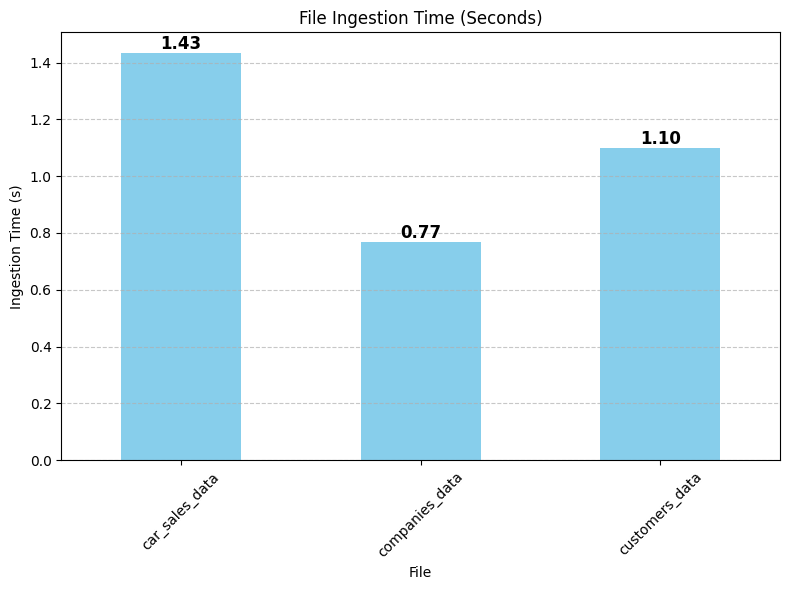

In [0]:
# Create the bar plot
ax = bronze_statistics_df.plot(kind="bar", x="file", y="ingestion_time_s", legend=False, figsize=(8, 6), color="skyblue")

# Add labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f"{p.get_height():.2f}", 
            fontsize=12, ha="center", va="bottom", fontweight="bold")

# Formatting
plt.title("File Ingestion Time (Seconds)")
plt.xlabel("File")
plt.ylabel("Ingestion Time (s)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

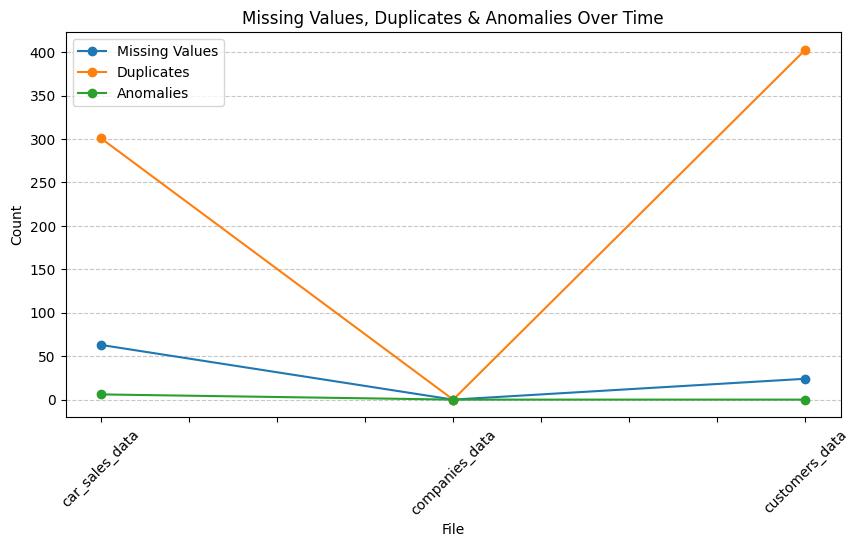

In [0]:
silver_statistics_df.plot(kind="line", x="file", y=["missing_values", "duplicates", "anomalies"], marker="o", figsize=(10, 5))
plt.title("Missing Values, Duplicates & Anomalies Over Time")
plt.xlabel("File")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(["Missing Values", "Duplicates", "Anomalies"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

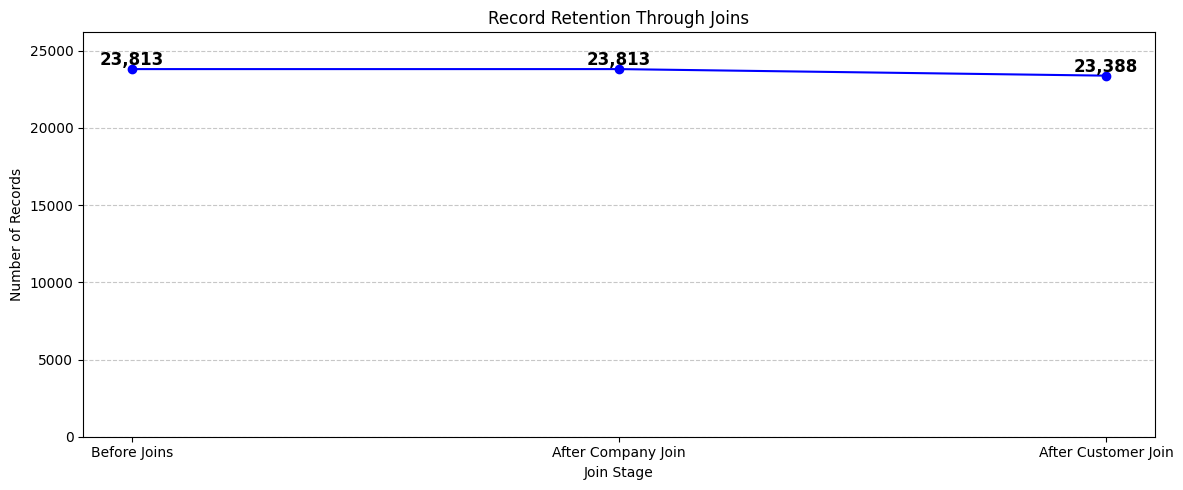

In [0]:
# Define the join stages and corresponding record counts
stages = ["Before Joins", "After Company Join", "After Customer Join"]
record_counts = [
    gold_statistics_df["car_sale_records_before_joins"].iloc[-1],  
    gold_statistics_df["car_sale_records_after_join_company"].iloc[-1],  
    gold_statistics_df["car_sale_records_after_join_customers"].iloc[-1]
]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(stages, record_counts, marker="o", linestyle="-", color="blue")

# Annotate each point with the exact record count
for i, count in enumerate(record_counts):
    plt.text(stages[i], count, f"{count:,}", fontsize=12, ha="center", va="bottom", fontweight="bold")

# Labels and Formatting
plt.title("Record Retention Through Joins")
plt.xlabel("Join Stage")
plt.ylabel("Number of Records")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, max(record_counts) * 1.1)  # Set Y-axis range slightly above max count
plt.tight_layout()

# Show Plot
plt.show()

# Saving Statistics

In [0]:
# Define JSON output paths for each statistics DataFrame
json_statistics_path = base_path.split("file:")[1] + "medallion/statistics.json"

# Convert timestamp columns to strings in each DataFrame
bronze_statistics_df["timestamp"] = bronze_statistics_df["timestamp"].astype(str)
silver_statistics_df["timestamp"] = silver_statistics_df["timestamp"].astype(str)
gold_statistics_df["timestamp"] = gold_statistics_df["timestamp"].astype(str)

# Convert each DataFrame to a list of dictionaries
bronze_dict = bronze_statistics_df.to_dict(orient="records")
silver_dict = silver_statistics_df.to_dict(orient="records")
gold_dict = gold_statistics_df.to_dict(orient="records")

# Create a final dictionary with keys for each statistic type
final_dict = {
    "bronze": bronze_dict,
    "silver": silver_dict,
    "gold": gold_dict
}

# Save the dictionary as a JSON file
try:
    with open(json_statistics_path, "w") as json_file:
        json.dump(final_dict, json_file, indent=4)
    print(f"JSON file saved to {json_statistics_path}")

    log_message("info", "medallion", "saving statistics", f"Medallion pipeline statistics JSON file saved to {json_statistics_path}")
except Exception as e:
    print(f"Error saving JSON file: {e}")
    log_message("error", "medallion", "saving statistics", f"Error saving Medallion pipeline statistics JSON file: {e}")

JSON file saved to /Workspace/Users/masa.cirkovic@abo.fi/medallion/statistics.json
